In this tutorial we introduce the DoG-HiT script as it is adapted in practice and discuss some more advanced options. Let us first load the modules and the data as usual.

In [16]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np

from imagingbase.ehtim_calibration import Calibrator
from imagingbase.minimization_handler import MinimizationHandler

import ehtplot.color
cfun = 'afmhot_u'

import pathlib 
current_path = str(pathlib.Path().absolute())

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

In [17]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 0.6                 # Total compact flux density (Jy)
npix      = 32                 # Number of pixels across the reconstructed image
fov       = 2*128*eh.RADPERUAS    # Field of view of the reconstructed image

prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise  = 0.02               # fractional systematic noise
                                # added to complex visibilities
                                                               
#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

stop      = 1e-4                # Imager stopping criterion
gain_tol  = [0.02,0.2]          # Asymmetric gain tolerance for self-cal; we expect larger values
                                # for unaccounted sensitivity loss
                                # than for unaccounted sensitivity improvement
uv_zblcut = 0.1e9               # uv-distance that separates the inter-site "zero"-baselines
                                # from intra-site baselines
zero_baseline = ['AA', 'AP']    # baseline to measure zero-spacing flux
rescaling = 0.0001              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 8*10**9]       #cbar-lims for interactive plotting (brightness temperature)

Loading uvfits:  /homes/hmueller/mr_beam/synthesis_regpy/examples/../synthetic_data/ring_eht2017.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  /homes/hmueller/mr_beam/synthesis_regpy/examples/../synthetic_data/ring.fits


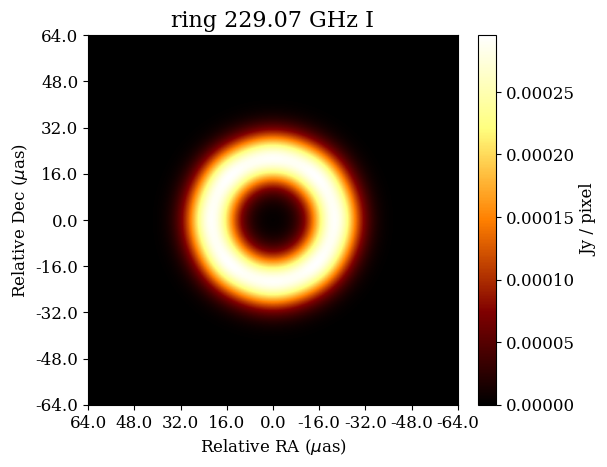

In [9]:
#-------------------------------------------------------------------------------
# Observe synthetic image and reduce/precalibrate synthetic observation
#-------------------------------------------------------------------------------

obs = eh.obsdata.load_uvfits(current_path+r'/../synthetic_data/ring_eht2017.uvfits')

#calibration object
cal = Calibrator(obs, zero_baseline, zbl, uv_zblcut, 0, sys_noise)
#prepare (coherently average) data
cal.prepare_data()
#precalibrate data
cal.precalibrate_data()

obs_sc = cal.obs_sc #precalibrated and reduced data set
obs_sc_init = obs_sc.copy()

exact_solution = eh.image.load_fits(current_path+r'/../synthetic_data/ring.fits')

exact_solution.display()

res = obs_sc.res()

In [18]:
prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))
prior = prior.add_gauss(1e-2*zbl, (prior_fwhm, prior_fwhm, 0, prior_fwhm, prior_fwhm))

What is the ideal wavelet dictionary to separate between features that are covered by observations and those that are not covered by observations? In Fourier domain this would be difference Bessel functions, in image domain we have seen that difference of Gaussian functions work best. Therefore, we adapt two different dictionaries in the following. We first fit the data with a dictionary that fits optimally to the uv-coverage, but contains many sidelobes, and then change to a dictionary with consisting out of Gaussians. For more details on this approach we refer to our discussion of DoB-CLEAN and Mueller,Lobanov 2023a. This changing can be achieved by the command: "handler.change_dictionary()"

Moreover, dictionaries should be directional dependent since the uv-coverage typically has a directional dependence. This is achieved by the usage of difference of elliptical Gaussian/Bessel functions, for more details we refer to Mueller, Lobanov 2023a. 

Let us first construct the handler. We identify with md=True that we want to use elliptical functions (with ellipticities the number of different angles per radial scale), and with bessels=True, that we want to use the two-dictionaries technique. 

In [19]:
#------------------------------------------------------------------------------
# Prepare Minimization Procedure
#------------------------------------------------------------------------------
#clean beam fwhm
psf_fwhm = res

#threshold for identifying gaps in uv-coverage
threshold = 3*10**8
#add short baselines wavelets 
short_bl_wl=[]
#add long baseline wavelets
long_bl_wl=[]
#fraction of fov to use for wavelets: ~0.5-1
ffov = 0.4
#find widths by wrapper method, arguments of 
from imagingbase.ehtim_wrapper import EhtimWrapper
wrapper = EhtimWrapper(obs_sc.copy(), prior.regrid_image(fov, npix+1), prior.regrid_image(fov, npix+1), zbl, debias=False)
widths = wrapper.find_widths(threshold, ffov)

#the final handler for the minimization procedure
handler = MinimizationHandler(psf_fwhm, npix, fov, obs_sc, prior, zbl, rescaling, data_term, cbar_lims, threshold, short_bl_wl, long_bl_wl, md=True, bessel=True, ellipticities=4, widths=widths) 
#widths of wavelet filters
widths = handler.widths

Generating I image...
Warning! Specified flux is < 80% of maximum visibility amplitude!
Generating I image...
Warning! Specified flux is < 80% of maximum visibility amplitude!
Generating I image...
Warning! Specified flux is < 80% of maximum visibility amplitude!
Generating I image...
Warning! Specified flux is < 80% of maximum visibility amplitude!
Generating I image...
Warning! Specified flux is < 80% of maximum visibility amplitude!


Next we would find a reasonable initial guess, self-calibrate, construct a mulitscalar and multidirectional coeeficient array, grid-search for the best solution, change the dictionary, run the DoG-HiT forward-backward splitting and find the multiresolution support. There is a shortcut for all these steps.

Round 1: Find initial guess ...
Warning! Specified flux is < 80% of maximum visibility amplitude!
Initializing imager data products . . .
U-V flagged 16/168 visibilities
U-V flagged 152/168 visibilities
Imager run 1 
Warning! Specified flux is < 80% of maximum visibility amplitude!
Imaging . . .
time: 0.316621 s
J: 47.408535
chi2_amp : 85.48 chi2_cphase : 15.10 chi2_logcamp : 17.36 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Warning! Specified flux is < 80% of maximum visibility amplitude!
Imaging . . .
time: 0.292694 s
J: 14.950216
chi2_amp : 57.78 chi2_cphase : 2.50 chi2_logcamp : 3.04 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Warning! Specified flux is < 80% of maximum visibility amplitude!
Imaging . . .
time: 0.321660 s
J: 10.626414
chi2_amp : 44.77 chi2_cphase : 1.81 chi2_logcamp : 2.06 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
Warning! Specified flux is < 80% of maximum visibility amplitude!
Imaging . . .
time: 0.303664 s
J: 9.2377

2023-09-14 13:39:27,248 INFO CountIterations      :: iteration = 1 / 25
2023-09-14 13:39:27,250 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:27,431 INFO CountIterations      :: iteration = 2 / 25
2023-09-14 13:39:27,432 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:27,613 INFO CountIterations      :: iteration = 3 / 25
2023-09-14 13:39:27,614 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:27,795 INFO CountIterations      :: iteration = 4 / 25
2023-09-14 13:39:27,796 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:27,978 INFO CountIterations      :: iteration = 5 / 25
2023-09-14 13:39:27,980 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:28,161 INFO CountIterations      :: iteration = 6 / 25
2023-09-14 13:39:28,162 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:28,344 INFO CountIterations      :: iteration = 7 / 25
2023

5479.076279262497
Data Fidelity:  35.848774746087926


2023-09-14 13:39:31,958 INFO CountIterations      :: iteration = 1 / 25
2023-09-14 13:39:31,959 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:32,140 INFO CountIterations      :: iteration = 2 / 25
2023-09-14 13:39:32,141 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:32,318 INFO CountIterations      :: iteration = 3 / 25
2023-09-14 13:39:32,319 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:32,499 INFO CountIterations      :: iteration = 4 / 25
2023-09-14 13:39:32,501 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:32,681 INFO CountIterations      :: iteration = 5 / 25
2023-09-14 13:39:32,682 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:32,863 INFO CountIterations      :: iteration = 6 / 25
2023-09-14 13:39:32,864 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:33,045 INFO CountIterations      :: iteration = 7 / 25
2023

5999.668278388255
Data Fidelity:  35.79850227873953


2023-09-14 13:39:36,645 INFO CountIterations      :: iteration = 1 / 25
2023-09-14 13:39:36,646 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:36,826 INFO CountIterations      :: iteration = 2 / 25
2023-09-14 13:39:36,828 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:37,008 INFO CountIterations      :: iteration = 3 / 25
2023-09-14 13:39:37,009 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:37,190 INFO CountIterations      :: iteration = 4 / 25
2023-09-14 13:39:37,191 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:37,372 INFO CountIterations      :: iteration = 5 / 25
2023-09-14 13:39:37,373 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:37,555 INFO CountIterations      :: iteration = 6 / 25
2023-09-14 13:39:37,556 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:37,737 INFO CountIterations      :: iteration = 7 / 25
2023

5999.668329844888
Data Fidelity:  35.748394567705


2023-09-14 13:39:41,307 INFO CountIterations      :: iteration = 1 / 25
2023-09-14 13:39:41,308 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:41,488 INFO CountIterations      :: iteration = 2 / 25
2023-09-14 13:39:41,489 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:41,670 INFO CountIterations      :: iteration = 3 / 25
2023-09-14 13:39:41,671 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:41,852 INFO CountIterations      :: iteration = 4 / 25
2023-09-14 13:39:41,853 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:42,034 INFO CountIterations      :: iteration = 5 / 25
2023-09-14 13:39:42,035 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:42,216 INFO CountIterations      :: iteration = 6 / 25
2023-09-14 13:39:42,217 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:42,415 INFO CountIterations      :: iteration = 7 / 25
2023

5999.668381272337
Data Fidelity:  35.69845076788009


2023-09-14 13:39:45,997 INFO CountIterations      :: iteration = 1 / 25
2023-09-14 13:39:45,999 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:46,183 INFO CountIterations      :: iteration = 2 / 25
2023-09-14 13:39:46,184 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:46,377 INFO CountIterations      :: iteration = 3 / 25
2023-09-14 13:39:46,378 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:46,561 INFO CountIterations      :: iteration = 4 / 25
2023-09-14 13:39:46,562 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:46,744 INFO CountIterations      :: iteration = 5 / 25
2023-09-14 13:39:46,745 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:46,927 INFO CountIterations      :: iteration = 6 / 25
2023-09-14 13:39:46,928 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:47,110 INFO CountIterations      :: iteration = 7 / 25
2023

5999.668432670704
Data Fidelity:  35.64867003982235


2023-09-14 13:39:50,683 INFO CountIterations      :: iteration = 1 / 25
2023-09-14 13:39:50,684 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:50,835 INFO CountIterations      :: iteration = 2 / 25
2023-09-14 13:39:50,836 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:51,021 INFO CountIterations      :: iteration = 3 / 25
2023-09-14 13:39:51,022 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:51,204 INFO CountIterations      :: iteration = 4 / 25
2023-09-14 13:39:51,205 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:51,386 INFO CountIterations      :: iteration = 5 / 25
2023-09-14 13:39:51,388 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:51,569 INFO CountIterations      :: iteration = 6 / 25
2023-09-14 13:39:51,570 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:51,752 INFO CountIterations      :: iteration = 7 / 25
2023

5999.668484040096
Data Fidelity:  35.599051549705656


2023-09-14 13:39:55,330 INFO CountIterations      :: iteration = 1 / 25
2023-09-14 13:39:55,331 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:55,512 INFO CountIterations      :: iteration = 2 / 25
2023-09-14 13:39:55,513 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:55,696 INFO CountIterations      :: iteration = 3 / 25
2023-09-14 13:39:55,698 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:55,879 INFO CountIterations      :: iteration = 4 / 25
2023-09-14 13:39:55,880 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:56,062 INFO CountIterations      :: iteration = 5 / 25
2023-09-14 13:39:56,063 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:56,244 INFO CountIterations      :: iteration = 6 / 25
2023-09-14 13:39:56,245 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:39:56,426 INFO CountIterations      :: iteration = 7 / 25
2023

5999.668535380604
Data Fidelity:  35.54959446927394


2023-09-14 13:40:00,028 INFO CountIterations      :: iteration = 1 / 25
2023-09-14 13:40:00,029 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:00,209 INFO CountIterations      :: iteration = 2 / 25
2023-09-14 13:40:00,211 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:00,392 INFO CountIterations      :: iteration = 3 / 25
2023-09-14 13:40:00,393 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:00,572 INFO CountIterations      :: iteration = 4 / 25
2023-09-14 13:40:00,574 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:00,754 INFO CountIterations      :: iteration = 5 / 25
2023-09-14 13:40:00,755 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:00,936 INFO CountIterations      :: iteration = 6 / 25
2023-09-14 13:40:00,937 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:01,118 INFO CountIterations      :: iteration = 7 / 25
2023

5999.668586692337
Data Fidelity:  35.50029797579626


2023-09-14 13:40:04,690 INFO CountIterations      :: iteration = 1 / 25
2023-09-14 13:40:04,691 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:04,872 INFO CountIterations      :: iteration = 2 / 25
2023-09-14 13:40:04,874 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:05,055 INFO CountIterations      :: iteration = 3 / 25
2023-09-14 13:40:05,056 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:05,237 INFO CountIterations      :: iteration = 4 / 25
2023-09-14 13:40:05,239 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:05,421 INFO CountIterations      :: iteration = 5 / 25
2023-09-14 13:40:05,422 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:05,604 INFO CountIterations      :: iteration = 6 / 25
2023-09-14 13:40:05,605 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:05,786 INFO CountIterations      :: iteration = 7 / 25
2023

5999.668637975388
Data Fidelity:  35.451161252021535


2023-09-14 13:40:09,375 INFO CountIterations      :: iteration = 1 / 25
2023-09-14 13:40:09,376 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:09,557 INFO CountIterations      :: iteration = 2 / 25
2023-09-14 13:40:09,558 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:09,738 INFO CountIterations      :: iteration = 3 / 25
2023-09-14 13:40:09,739 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:09,922 INFO CountIterations      :: iteration = 4 / 25
2023-09-14 13:40:09,923 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:10,104 INFO CountIterations      :: iteration = 5 / 25
2023-09-14 13:40:10,105 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:10,287 INFO CountIterations      :: iteration = 6 / 25
2023-09-14 13:40:10,288 INFO Display              :: Penalty--> 143.8201205761652
2023-09-14 13:40:10,469 INFO CountIterations      :: iteration = 7 / 25
2023

5999.668689229851
Data Fidelity:  35.40218348613459


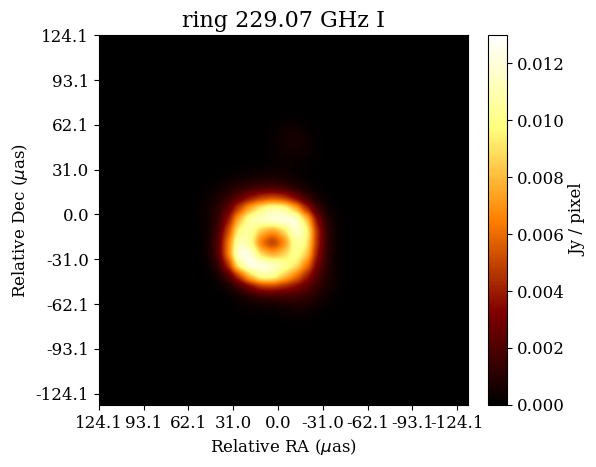

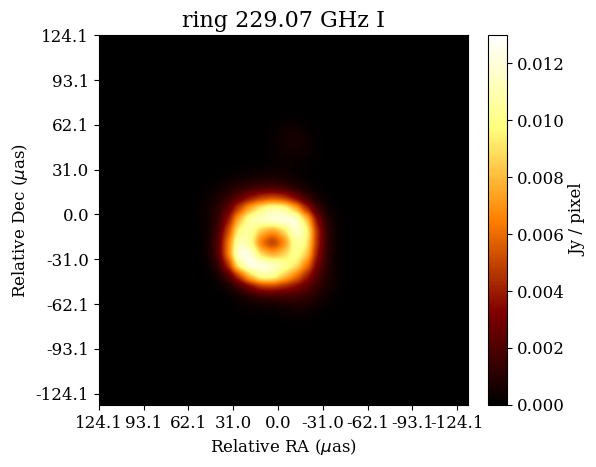

In [20]:
#------------------------------------------------------------------------------
# Run DoG-HiT
#------------------------------------------------------------------------------
alpha=0.1 #wavelet sparsity constraint
tau=1 #stepsize in minimization
img2, wtfcts2, table1, obs_sc = handler.doghit(prior, data_term, cycles=5, last_epochs=True, solution_interval=600, alpha=alpha, tau=tau, maxiter=10, display=False)
img2.display()

Since we are doing the imaging from the closure quantities, the reconstruction is independent against rescaling the reconstruction with a constant factor. Now, we calibrate the total flux. For this, we fix the relative structure, rescale the field with various constants and compute the chi-squared fit to the (uncalibrated) amplitudes. This is handled by the following command.

In [21]:
img2, wtfcts2, table2, obs_sc = handler.calibrate_full(obs_sc, obs_sc_init, img2, wtfcts2, uv_zblcut=uv_zblcut)

U-V flagged 152/168 visibilities
Generating I image...
Warning! Specified flux is > 120% of maximum visibility amplitude!
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 0.873485 s
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 0.870097 s


Now we add the usual refining steps

Third Round: Multiscalar Imaging with visibility amplitudes and closure quantities ...


2023-09-14 13:42:41,388 INFO CountIterations      :: iteration = 1 / 5
2023-09-14 13:42:41,490 INFO Display              :: Data Fidelity--> 46.22590609174807
2023-09-14 13:42:41,764 INFO CountIterations      :: iteration = 2 / 5
2023-09-14 13:42:41,866 INFO Display              :: Data Fidelity--> 46.13466680931092
2023-09-14 13:42:42,141 INFO CountIterations      :: iteration = 3 / 5
2023-09-14 13:42:42,243 INFO Display              :: Data Fidelity--> 46.0438670728894
2023-09-14 13:42:42,531 INFO CountIterations      :: iteration = 4 / 5
2023-09-14 13:42:42,634 INFO Display              :: Data Fidelity--> 45.953503732156065
2023-09-14 13:42:42,933 INFO CountIterations      :: iteration = 5 / 5
2023-09-14 13:42:42,933 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-09-14 13:42:42,934 INFO Gradient_Descent     :: Stopping rule triggered.
2023-09-14 13:42:43,347 INFO CountIterations      :: iteration = 1 / 5
2023-09-14 13:42:43,451 INFO Display     

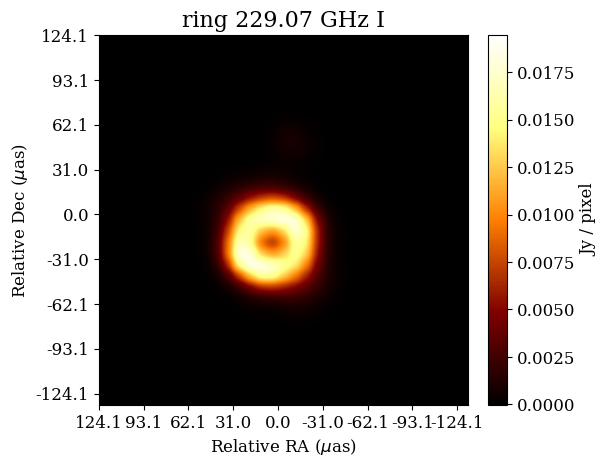

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 0.872122 s
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 0.861000 s


In [22]:
#-------------------------
# Third Round of Imaging: amplitude+closure-quantities + multiresolution support constraint
#-------------------------

print("Third Round: Multiscalar Imaging with visibility amplitudes and closure quantities ...")

#We add amplitudes to the constrained minimization
#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

#run gradient descent minimization
#stepsize automatically found
wtfcts3, img3, tau = handler.third_round(wtfcts2, data_term, tau=tau, maxit=100)

img3.display()

#phase-calibration
table3 = eh.selfcal(obs_sc, img3, method='both', ttype=ttype, solution_interval=3600, caltable=True)
obs_sc = eh.selfcal(obs_sc, img3, method='both', ttype=ttype, solution_interval=3600)
handler.updateobs(obs_sc.copy())

Round 4: Multiscalar Imaging with visibilities and closure quantities ...


2023-09-14 13:46:24,947 INFO CountIterations      :: iteration = 1 / 5
2023-09-14 13:46:25,050 INFO Display              :: Data Fidelity--> 52.807244254021434
2023-09-14 13:46:25,326 INFO CountIterations      :: iteration = 2 / 5
2023-09-14 13:46:25,428 INFO Display              :: Data Fidelity--> 52.68768292644869
2023-09-14 13:46:25,708 INFO CountIterations      :: iteration = 3 / 5
2023-09-14 13:46:25,811 INFO Display              :: Data Fidelity--> 52.568863990401894
2023-09-14 13:46:26,088 INFO CountIterations      :: iteration = 4 / 5
2023-09-14 13:46:26,193 INFO Display              :: Data Fidelity--> 52.45078046407222
2023-09-14 13:46:26,470 INFO CountIterations      :: iteration = 5 / 5
2023-09-14 13:46:26,471 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-09-14 13:46:26,471 INFO Gradient_Descent     :: Stopping rule triggered.
2023-09-14 13:46:26,888 INFO CountIterations      :: iteration = 1 / 5
2023-09-14 13:46:26,992 INFO Display   

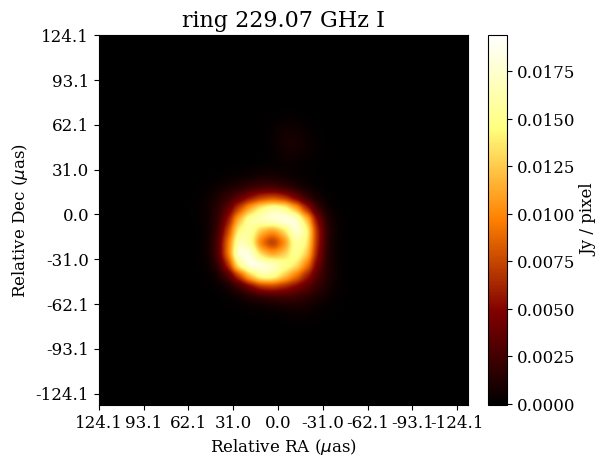

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 0.904760 s
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 0.906389 s


In [23]:
#-------------------------
# Fourth Round of Imaging: visibilities+closure_quantities + multiresolution support contraint
#-------------------------

print("Round 4: Multiscalar Imaging with visibilities and closure quantities ...")

#data weights
data_term = {'vis'    : 1.0,    # visibilities
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

#run gradient descent minimization
#stepsize automatically found
coeff, img4, tau = handler.fourth_round(wtfcts3, data_term, tau=tau, maxit=100)

#img4.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)
img4.display()

#phase+amplitude calibration
table4 = eh.selfcal(obs_sc, img4, method='both', ttype=ttype, solution_interval=3600, caltable=True)
obs_sc = eh.selfcal(obs_sc, img4, method='both', ttype=ttype, solution_interval=3600)
handler.updateobs(obs_sc.copy())


2023-09-14 13:49:38,857 INFO CountIterations      :: iteration = 1 / 5
2023-09-14 13:49:38,871 INFO Display              :: Data Fidelity--> 43.89132284100356
2023-09-14 13:49:38,883 INFO CountIterations      :: iteration = 2 / 5
2023-09-14 13:49:38,889 INFO Display              :: Data Fidelity--> 43.7498700701777
2023-09-14 13:49:38,897 INFO CountIterations      :: iteration = 3 / 5
2023-09-14 13:49:38,899 INFO Display              :: Data Fidelity--> 43.60974922457538
2023-09-14 13:49:38,930 INFO CountIterations      :: iteration = 4 / 5
2023-09-14 13:49:38,934 INFO Display              :: Data Fidelity--> 43.47094248302987
2023-09-14 13:49:38,941 INFO CountIterations      :: iteration = 5 / 5
2023-09-14 13:49:38,942 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-09-14 13:49:38,944 INFO Gradient_Descent     :: Stopping rule triggered.
2023-09-14 13:49:38,950 INFO CountIterations      :: iteration = 1 / 5
2023-09-14 13:49:38,955 INFO Display      

Round 5: Single Scalar Imaging with visibilities ...


2023-09-14 13:49:39,055 INFO Display              :: Data Fidelity--> 42.27803378429964
2023-09-14 13:49:39,063 INFO CountIterations      :: iteration = 4 / 5
2023-09-14 13:49:39,066 INFO Display              :: Data Fidelity--> 42.15145697783296
2023-09-14 13:49:39,073 INFO CountIterations      :: iteration = 5 / 5
2023-09-14 13:49:39,075 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-09-14 13:49:39,076 INFO Gradient_Descent     :: Stopping rule triggered.
2023-09-14 13:49:39,094 INFO CountIterations      :: iteration = 1 / 5
2023-09-14 13:49:39,097 INFO Display              :: Data Fidelity--> 41.90170383985138
2023-09-14 13:49:39,102 INFO CountIterations      :: iteration = 2 / 5
2023-09-14 13:49:39,105 INFO Display              :: Data Fidelity--> 41.778499094995425
2023-09-14 13:49:39,110 INFO CountIterations      :: iteration = 3 / 5
2023-09-14 13:49:39,119 INFO Display              :: Data Fidelity--> 41.65639036543344
2023-09-14 13:49:39,128

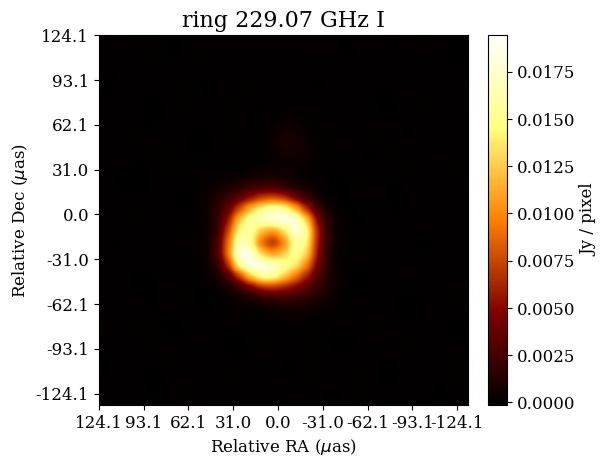

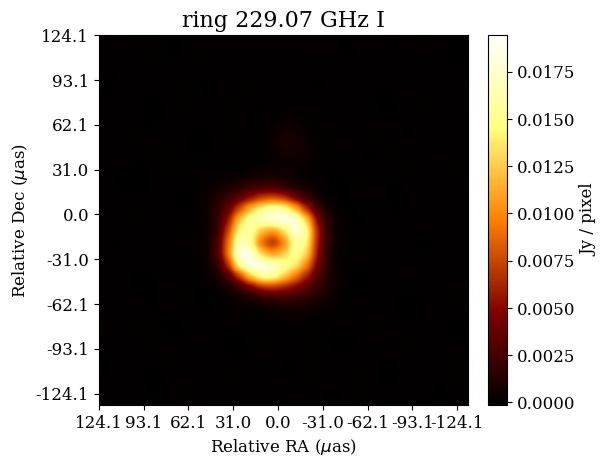

In [24]:
#-------------------------
# Fifth Round of Imaging: visibilities
#-------------------------

print("Round 5: Single Scalar Imaging with visibilities ...")

#project solution to postive values
init = np.maximum(0, img4.imarr()/rescaling)

#run gradient descent minimization
#stepsize automatically found
img = handler.fifth_round(init.copy(), data_term, tau=tau, maxit=1000)

#img.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)
img.display()